Pipeline Progress:  67%|████████████████        | 2/3 [00:04<00:02,  2.38s/step]

After sampling, class distribution in y_train: Counter({0: 711100, 1: 711100})
[LightGBM] [Info] Number of positive: 711100, number of negative: 711100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3787
[LightGBM] [Info] Number of data points in the train set: 1422200, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Pipeline Progress: 100%|████████████████████████| 3/3 [00:06<00:00,  2.43s/step]

Model saved as final_gst_model.joblib
Accuracy: 0.9734135232622119
Precision: 0.7850891305746831
Recall: 0.9886943836615609
F1 Score: 0.875206255828969
AUC-ROC: 0.9941250796954446
Log Loss: 0.07138120292503693
Balanced Accuracy: 0.9802584956943612
Confusion Matrix:
[[230355   6679]
 [   279  24399]]


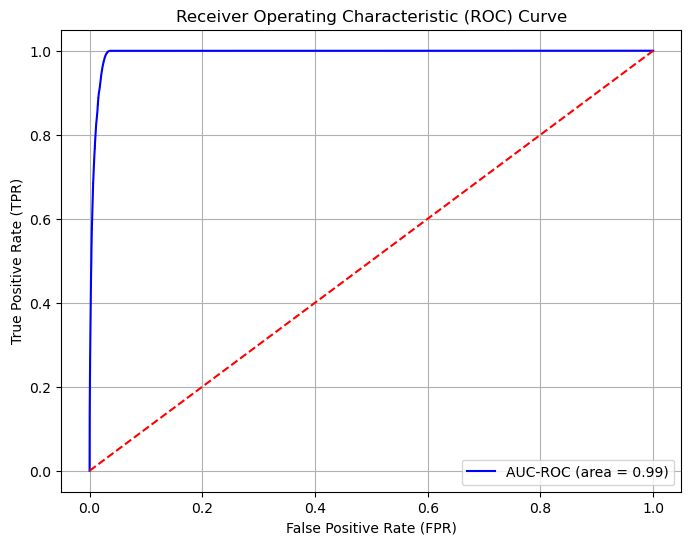

Pipeline Progress: 100%|████████████████████████| 3/3 [00:07<00:00,  2.48s/step]


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix as sklearn_cm, log_loss, balanced_accuracy_score, roc_curve)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # Pipeline for imbalanced data handling
import lightgbm as lgb
import matplotlib.pyplot as plt
from tqdm import tqdm  # Progress bar
from sklearn.pipeline import Pipeline  # Standard pipeline
from collections import Counter  # Used to count class distribution in y_train
import joblib  # For saving and loading the model
import os  # For checking file existence


# Function to load custom test dataset (provided by jury)
def load_custom_test_data(file_path):
    """
    Loads the custom test dataset from the provided file path.
    Assumes 'target' column is present in the dataset.

    Args:
        file_path (str): Path to the test dataset file.
    
    Returns:
        X_test (pd.DataFrame): Features of the test dataset.
        y_test (pd.Series): Target values of the test dataset.
    """
    test_data = pd.read_csv(file_path)
    y_test = test_data['target']
    X_test = test_data.drop(columns=['target', 'ID'], axis=1)
    return X_test, y_test


# Function to drop highly correlated features
def drop_high_correlation(X, threshold=0.9):
    """
    Drops features in the dataset X that have a correlation greater than the specified threshold.

    Args:
        X (pd.DataFrame): The input feature dataset.
        threshold (float): Correlation threshold above which features will be dropped.
    
    Returns:
        X (pd.DataFrame): DataFrame with highly correlated features dropped.
        to_drop (list): List of dropped features.
    """
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return X.drop(columns=to_drop, axis=1), to_drop


# Function to build preprocessing pipeline for numerical and categorical features
def build_preprocessing_pipeline(X_train):
    """
    Builds a preprocessing pipeline for numerical and categorical columns.

    Args:
        X_train (pd.DataFrame): The training dataset.
    
    Returns:
        preprocessor (ColumnTransformer): A preprocessor with pipelines for both numerical and categorical features.
    """
    numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

    # Imputers and transformers for numerical and categorical data
    num_imputer = SimpleImputer(strategy='median')
    cat_imputer = SimpleImputer(strategy='most_frequent')
    scaler = StandardScaler()
    encoder = OrdinalEncoder()

    # Preprocessor pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[('imputer', num_imputer), ('scaler', scaler)]), numerical_cols),
            ('cat', Pipeline(steps=[('imputer', cat_imputer), ('encoder', encoder)]), categorical_cols)
        ]
    )

    return preprocessor


# Function to save the trained model to a file
def save_model(pipeline, model_name='final_model.joblib'):
    """
    Saves the trained pipeline (model) to a file using joblib.

    Args:
        pipeline (Pipeline): The trained model pipeline to be saved.
        model_name (str): The file name where the model will be saved.
    """
    joblib.dump(pipeline, model_name)
    print(f"Model saved as {model_name}")


# Function to load a saved model
def load_model(model_file):
    """
    Loads a saved model pipeline from a file.

    Args:
        model_file (str): Path to the saved model file.
    
    Returns:
        model (Pipeline): The loaded model pipeline.
    """
    if os.path.exists(model_file):
        model = joblib.load(model_file)
        print(f"Model loaded from {model_file}")
        return model
    else:
        raise FileNotFoundError(f"{model_file} does not exist.")


# Function to evaluate the model performance
def evaluate_model(pipeline, X_train, y_train, X_test, y_test, save=False, model_name='final_model.joblib'):
    """
    Evaluates the model's performance by fitting the pipeline, making predictions,
    and calculating various metrics such as accuracy, precision, recall, F1 score, AUC-ROC, etc.
    
    Args:
        pipeline (Pipeline): The machine learning pipeline (SMOTE + LGBM).
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target labels.
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): Test target labels.
        save (bool): Whether to save the trained model after evaluation.
        model_name (str): File name to save the trained model.
    """
    steps = len(pipeline.steps)
    progress_bar = tqdm(total=steps, desc="Pipeline Progress", unit="step")

    # Fit and transform steps of the pipeline except the classifier
    for name, step in pipeline.steps[:-1]:
        if hasattr(step, 'fit_resample'):
            X_train, y_train = step.fit_resample(X_train, y_train)
            print(f"After {name}, class distribution in y_train: {Counter(y_train)}")
        elif hasattr(step, 'fit'):
            step.fit(X_train, y_train)
        progress_bar.update(1)

        if hasattr(step, 'transform'):
            X_train = step.transform(X_train)
            X_test = step.transform(X_test)

    # Final step: classifier
    classifier_name, classifier = pipeline.steps[-1]
    classifier.fit(X_train, y_train)
    progress_bar.update(1)

    # Save the model if required
    if save:
        save_model(pipeline, model_name)

    # Make predictions
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]

    # Metrics calculations
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba)
    cm = sklearn_cm(y_test, y_pred)
    logloss = log_loss(y_test, y_pred_proba)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    # Display metrics
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC-ROC: {auc}")
    print(f"Log Loss: {logloss}")
    print(f"Balanced Accuracy: {balanced_acc}")
    print(f"Confusion Matrix:\n{cm}")

    # Plot AUC-ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'AUC-ROC (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Close progress bar
    progress_bar.close()


# Main function to run the pipeline and optionally save the model
def run_final_pipeline(X_train, y_train, custom_test_file_path, save_model_flag=False, model_name='final_model.joblib'):
    """
    Runs the full pipeline including preprocessing, SMOTE, and classification
    on the provided training and test datasets, and optionally saves the trained model.

    Args:
        X_train (pd.DataFrame): Training dataset features.
        y_train (pd.Series): Training dataset target.
        custom_test_file_path (str): Path to the custom test dataset file.
        save_model_flag (bool): Whether to save the trained model.
        model_name (str): File name to save the trained model.
    """
    # Preprocessing pipeline
    preprocessor = build_preprocessing_pipeline(X_train)
    
    # Create a pipeline with SMOTE for oversampling and LightGBM for classification
    smote = SMOTE(random_state=42)
    lgbm_model = lgb.LGBMClassifier(device_type='cpu', random_state=42, n_jobs=-1)  # Multi-threading enabled
    pipeline = ImbPipeline(steps=[('preprocessing', preprocessor), ('sampling', smote), ('classification', lgbm_model)])

    # Load the custom test dataset
    X_test, y_test = load_custom_test_data(custom_test_file_path)

    # Evaluate the model and optionally save it
    evaluate_model(pipeline, X_train, y_train, X_test, y_test, save=save_model_flag, model_name=model_name)


# Example usage
if __name__ == "__main__":
    # Load the training dataset (replace with actual paths)
    data_path = "complete_data/Train_60/Train_60"
    X_train = pd.read_csv(f'{data_path}/X_Train_Data_Input.csv')
    y_train = X_train['target']
    X_train = X_train.drop(['target', 'ID'], axis=1)

    # Run the pipeline with a custom test dataset file and save the trained model
    custom_test_file_path = "complete_data/Test_20/Test_20/X_Test_Data_Input.csv"
    run_final_pipeline(X_train, y_train, custom_test_file_path, save_model_flag=True, model_name='final_gst_model.joblib')
